<a href="https://colab.research.google.com/github/AmlaanKar96/dog-breed-classification/blob/main/dog_breed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
from keras.engine import  Model
from __future__ import absolute_import, division, print_function
import os
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, MaxPooling2D,Flatten
import pickle
import glob
import matplotlib
from keras.models import *
from keras.layers import *
import keras.backend as K
from types import MethodType
from tqdm import tqdm
import random
import itertools
import copy
from sklearn.neighbors import DistanceMetric
from keras.layers.core import Lambda, Dense
import math
from sklearn.preprocessing import StandardScaler
from scipy import spatial
from skimage import color
from keras.preprocessing.image import ImageDataGenerator

Filenames to be separated into different directories for ImageDataGenerator

In [ ]:
filenames=glob.glob('/content/drive/My Drive/Colab Notebooks/Kaggle/dog-breed-identification/train/*')
filenames=sorted(filenames)
filenames=sorted(filenames,key=len)

List of all images

In [ ]:
from skimage import color
train=[]
for i in range(len(filenames)):
    img=Image.open(filenames[i])
    img=img.convert('RGB')
    img=img.resize(size=(224,224))
    img=np.array(img)
    train.append(img)

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/Kaggle/dog-breed-identification/train.pkl', 'wb') as f:
    pickle.dump(train, f, pickle.HIGHEST_PROTOCOL)
# with open('/content/drive/My Drive/Colab Notebooks/Kaggle/dog-breed-identification/train_normalized.pkl', 'wb') as f:
#     pickle.dump([train,trainl], f, pickle.HIGHEST_PROTOCOL)

In [ ]:
def load_dict(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
# train,trainl=load_dict('/content/drive/My Drive/Colab Notebooks/Kaggle/dog-breed-identification/train_normalized.pkl')
train=load_dict('/content/drive/My Drive/Colab Notebooks/Kaggle/dog-breed-identification/train.pkl')

List of labels

In [4]:
import pandas as pd
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Kaggle/dog-breed-identification/labels.csv')

In [5]:
label_dict={}
labels=['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff', 'other']
for i in range(len(labels)):
  label_dict[labels[i]]=i

In [6]:
df=df.values

In [ ]:
df_dict={}
for i in df:
    df_dict[i[0]]=i[1]
train_data=[]
for i in range(len(filenames)):
    ret=filenames[i].split('/')[-1].split('.')[0]
    try:
        ret1=label_dict[df_dict[ret]]
    except:
        # continue
        ret1=label_dict['other']
    train_data.append([train[i],ret1])

Separate into train-test by 70:30 split

In [ ]:
random.shuffle(filenames)
train_names = filenames[:int(0.7*len(filenames))]
test_names = filenames[int(0.7*len(filenames)):]

Save images classwise in new folder for Keras ImageDataGenerator

In [ ]:
import shutil, os
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
for i in range(len(train_names)):
    ret=train_names[i].split('/')[-1].split('.')[0]
    try:
        ret1=df_dict[ret]
        img = load_img(train_names[i], target_size=(224, 224))
        img_array = img_to_array(img)
        img_ready = preprocess_input(img_array)
        cv.imwrite('/content/drive/My Drive/Colab Notebooks/Kaggle/dog-breed-identification/data1/train/'+ret1+'/'+train_names[i].split('/')[-1],img_ready)
    except:
        continue

for i in range(len(test_names)):
    ret=test_names[i].split('/')[-1].split('.')[0]
    try:
        ret1=df_dict[ret]
        img = load_img(test_names[i], target_size=(224, 224))
        img_array = img_to_array(img)
        img_ready = preprocess_input(img_array)
        cv.imwrite('/content/drive/My Drive/Colab Notebooks/Kaggle/dog-breed-identification/data1/test/'+ret1+'/'+test_names[i].split('/')[-1],img_ready)
    except:
        continue

Keras ImageDataGenerator with data augmentation

In [8]:
src_path_train = "/content/drive/My Drive/Colab Notebooks/Kaggle/dog-breed-identification/data1/train/"
src_path_test = "/content/drive/My Drive/Colab Notebooks/Kaggle/dog-breed-identification/data1/test/"

train_datagen = ImageDataGenerator(
        featurewise_center=True,
        samplewise_center=True,
        featurewise_std_normalization=True,
        samplewise_std_normalization=True,
        # rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator()#rescale=1 / 255.0)

In [9]:
batch_size = 16
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 484 images belonging to 10 classes.
Found 116 images belonging to 10 classes.
Found 241 images belonging to 10 classes.


Training a ResNet50 with top removed and 4 FC layers added. Using Imagenet weights helps in improving performance by ~17% compared to training a freshly initialized Resnet50, which overfits quickly. I froze the whole model except the last 4 layers, which are trained for 100 epochs using the augmented dataset. The results obtained work well only for 5 classes, which we increase to 8 by training the model for 20 epochs using the class weights shown in the code.

In [14]:
base_model = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=None,
    pooling='avg'
)
for layer in base_model.layers:
    layer.trainable = False
x=tf.keras.layers.Dropout(.5)(base_model.output)
x=Dense(512)(x)
x=tf.keras.layers.Dropout(.5)(x)
x=Dense(256)(x)
x=tf.keras.layers.Dropout(.5)(x)
x=Dense(64)(x)
x=tf.keras.layers.Dropout(.5)(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/Kaggle/dog-breed-identification/mdl_wts1.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',metrics=['accuracy']
)
model.fit(
        train_generator,
        epochs=100,
        validation_data=valid_generator)#,callbacks=[mcp_save],class_weight={0:2,1:2,2:2,3:7,4:7,5:7,6:2,7:7,8:1,9:7})

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
31/31 [==============================] - 12s 295ms/step - loss: 0.3116 - accuracy: 0.3435 - val_loss: 0.2948 - val_accuracy: 0.3707
Epoch 2/100
31/31 [==============================] - 8s 268ms/step - loss: 0.3156 - accuracy: 0.3143 - val_loss: 0.2954 - val_accuracy: 0.3276
Epoch 3/100
31/31 [==============================] - 8s 272ms/step - loss: 0.3067 - accuracy: 0.3596 - val_loss: 0.3006 - val_accuracy: 0.3534
Epoch 4/100
31/31 [==============================] - 8s 269ms/step - loss: 0.3119 - accuracy: 0.3136 - val_loss: 0.2910 - val_accuracy: 0.3190
Epoch 5/100
31/31 [==============================] - 8s 277ms/step - loss: 0.3035 - accuracy: 0.3721 - val_loss: 0.2948 - val_accuracy: 0.2845
Epoch 6/100
31/31 [==============================] - 8s 272ms/step - loss: 0.2986 - accuracy: 0.3374 - val_loss: 0.2939 - val_accuracy: 0.3534
Epoch 7/100
31/31 [==============================] - 8s 270ms/step - loss: 0.2913 - accuracy: 0.3793 - val_loss: 0.2982 - val_accuracy: 0.301

In [13]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/Kaggle/dog-breed-identification/mdl_wts1.hdf5')

In [12]:
from sklearn import metrics
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                    precision    recall  f1-score   support

            beagle       0.33      0.18      0.23        28
         chihuahua       0.25      0.29      0.27        21
          doberman       0.31      0.15      0.21        26
    french_bulldog       0.00      0.00      0.00        15
  golden_retriever       0.23      0.52      0.32        25
          malamute       1.00      0.29      0.45        17
               pug       0.22      0.69      0.34        29
     saint_bernard       0.71      0.25      0.37        20
scottish_deerhound       0.55      0.40      0.46        40
   tibetan_mastiff       0.00      0.00      0.00        20

          accuracy                           0.31       241
         macro avg       0.36      0.28      0.26       241
      weighted avg       0.37      0.31      0.29       241



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
tg={}
for i in test_generator.class_indices:
    tg[test_generator.class_indices[i]]=i
tg

{0: 'beagle',
 1: 'chihuahua',
 2: 'doberman',
 3: 'french_bulldog',
 4: 'golden_retriever',
 5: 'malamute',
 6: 'pug',
 7: 'saint_bernard',
 8: 'scottish_deerhound',
 9: 'tibetan_mastiff'}

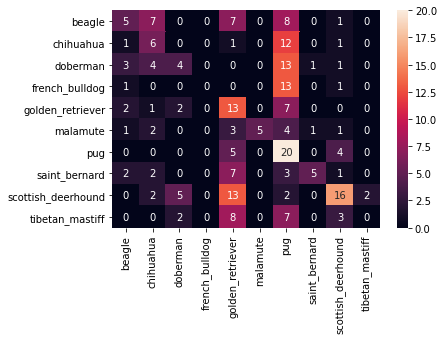

In [14]:
from sklearn.metrics import confusion_matrix,accuracy_score
import pandas as pd
cm=confusion_matrix(true_classes, predicted_classes)
columns = [i for i in list(test_generator.class_indices.keys())]
import seaborn as sns
df_cm = pd.DataFrame(cm, index=columns, columns=columns)
sns.heatmap(df_cm,annot=True)

In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(true_classes,predictions,multi_class='ovr'))
print(accuracy_score(true_classes,predicted_classes))

0.7020200920696644
0.25311203319502074


Locally Deploy app using dog_breed_app.ipynb. Test app using dog_breed_final_run.ipynb